In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
%matplotlib inline

In [9]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [10]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [11]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data/data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data/data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X = train_data['data'].astype('float64')
y = train_data['target']
y_oh = np.array(list(map(lambda x : encoder.transform(x), y)))
X_delay = test_data['data'].astype('float64')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_oh, stratify=y,
                                                    random_state=42, test_size=0.05)

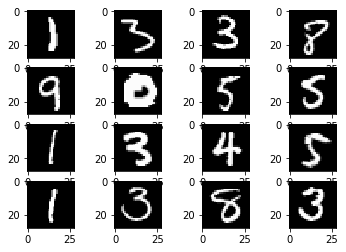

In [13]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [14]:
# Подготовка датасета
# Отнормируем данные
scalar = StandardScaler().fit(X_train)

X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)
X_delay = scalar.transform(X_delay)

### Определим слои нейронной сети:

* #### Полносвязный слой (Dense)

In [15]:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2 / in_size)
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

* #### Нелинейная функция активации: ReLu

In [16]:
class ReLU:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz

* #### Softmax

In [17]:
# TODO
class Softmax:
    def calc(self, x):
        res = np.exp(x)
        return res / res.sum()
    
    def forward(self, x):
        self.x = x
        return self.calc(x)
    
    def backward(self, dz, lr=0.001):
        sigm = self.calc(self.x)[np.newaxis, :]
        return np.dot(np.diagflat(sigm) - np.dot(sigm.T, sigm), dz)

* #### Loss: кросс-энтропия

In [18]:
class CrossEntropy:    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum(y_true * np.log(self.y_hat))
    
    def backward(self, dz, lr=0.001):
        return (-1) * (self.y_true / self.y_hat) * dz

### Определим саму нейронную сеть

In [19]:
class MnistNet:
    def __init__(self, rlambda=0.0):
        self.d1 = Dense(784, 256, rlambda)
        self.r1 = ReLU()
        self.d2 = Dense(256, 10, rlambda)
        self.r2 = ReLU()
        self.s1 = Softmax()
    
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.r1.forward(net)
        net = self.d2.forward(net)
        net = self.r2.forward(net)
        net = self.s1.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s1.backward(dz, lr)
        dz = self.r2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.r1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz

### Перейдём к процедуре обучения

* #### Объявим функции логирования

In [20]:
def compute_loss(X, y, net, loss, lr=None):
    # Функция для вычисления значение потери y в формате onehot
    assert(X.shape[0] == y.shape[0])
    n = X.shape[0]
    
    if lr is not None:
        indxs = list(range(n))
        np.random.shuffle(indxs)
        X = X[indxs]
        y = y[indxs]
        
    res_loss = 0
    for i in range(n):
        y_pred = net.forward(X[i])

        curr_loss = loss.forward(y[i], y_pred) + net.d1.get_reg_loss()  + \
                                                 net.d2.get_reg_loss() 
        res_loss += curr_loss
        if lr is not None:
            dz = loss.backward(1, lr)
            dz = net.backward(dz, lr)
    
    return res_loss / n

def compute_acc(X, y, net):
    # Функция для вычисления значение потери y в формате onehot
    assert(X.shape[0] == y.shape[0])
    n = X.shape[0]
    
    res_acc = 0.0
    for i in range(n):
        y_p = net.forward(X[i])
        y_pred = np.argmax(y_p)
        y_real = np.argmax(y[i])
        
        if(y_pred == y_real):
            res_acc += 1.0
            
    return res_acc / n

* #### Объявим константы для процедуры обучения

In [21]:
net = MnistNet(rlambda=0.0001)
loss = CrossEntropy()
lr = 0.001
epoch_num = 80

L_train, L_test = [], []
Acc_train, Acc_test = [], []

* #### Непосредственно сама процедура обучения

In [22]:
for iter in tqdm_notebook(range(epoch_num)):
    L_train.append(compute_loss(X_train, y_train, net, loss, lr=lr))
    L_test.append(compute_loss(X_test, y_test, net, loss))
    Acc_train.append(compute_acc(X_train, y_train, net))
    Acc_test.append(compute_acc(X_test, y_test, net))

HBox(children=(IntProgress(value=0, max=80), HTML(value='')))

### Обработка результатов

* #### Сравнение кросс энтропии для тренировочной и тестовой выборок

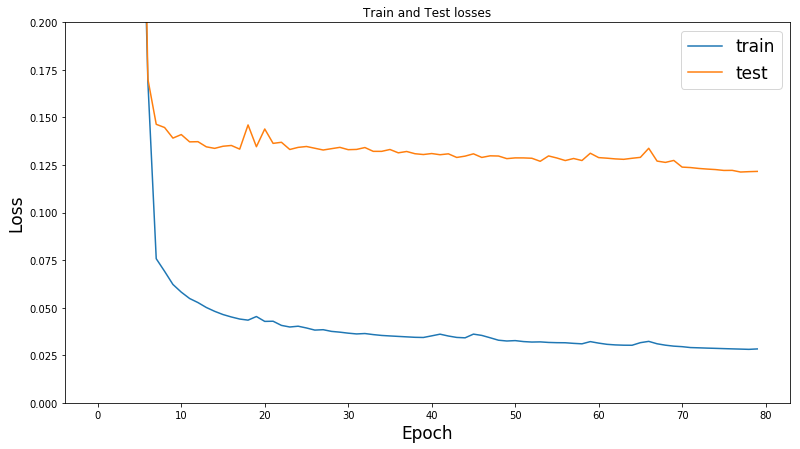

In [23]:
plt.figure(figsize=(13, 7))
plt.title('Train and Test losses')
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Loss', fontsize=17)
plt.ylim(0, 0.2)

plt.plot(L_train, label='train')
plt.plot(L_test, label='test')
plt.legend(fontsize=17)
plt.show()

* #### Сравнение точности для тренировочной и тестовой выборок

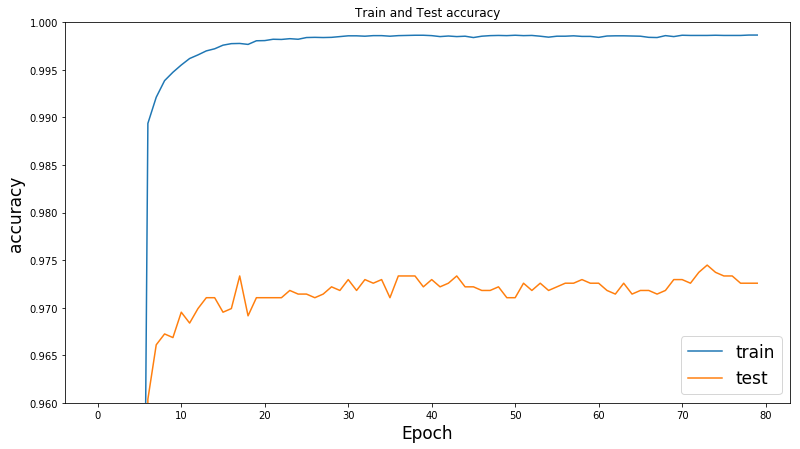

In [24]:
plt.figure(figsize=(13, 7))
plt.title('Train and Test accuracy')
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('accuracy', fontsize=17)
plt.ylim(0.96, 1)

plt.plot(Acc_train, label='train')
plt.plot(Acc_test, label='test')
plt.legend(fontsize=17)
plt.show()

* #### Сохранение результата для отложенной выборки

In [25]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_delay, net)